<a href="https://colab.research.google.com/github/SPauloG/Bootcamp_BairesDevDio/blob/main/sistema_de_reconhecimento_facial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
#required libraries
!pip install tensorflow==2.13.0 opencv-python-headless==4.8.0.74 mtcnn==0.1.1 scikit-learn

In [16]:
#Import necessary libraries
import os
import numpy as np
import cv2
from mtcnn import MTCNN
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import files
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [17]:
#Define characters and create dataset structure
characters = ['Sheldon', 'Leonard']
num_classes = len(characters)

def create_dataset_structure():
    base_dir = '/content/tbbt_dataset'
    if not os.path.exists(base_dir):
        os.makedirs(base_dir)

    for character in characters:
        char_dir = os.path.join(base_dir, character)
        if not os.path.exists(char_dir):
            os.makedirs(char_dir)

    print("Please upload character images to their respective folders in /content/tbbt_dataset/")
    return base_dir

dataset_path = create_dataset_structure()

Please upload character images to their respective folders in /content/tbbt_dataset/


In [18]:
#Define functions for face extraction and data preparation
detector = MTCNN()

def extract_face(image, required_size=(224, 224)):
    faces = detector.detect_faces(image)
    if faces:
        x, y, width, height = faces[0]['box']
        face = image[y:y+height, x:x+width]
        face = cv2.resize(face, required_size)
        return face
    return None

def prepare_data(dataset_path):
    X, y = [], []
    for character in characters:
        character_path = os.path.join(dataset_path, character)
        for image_name in os.listdir(character_path):
            image_path = os.path.join(character_path, image_name)
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            face = extract_face(image)
            if face is not None:
                X.append(face)
                y.append(characters.index(character))
    return np.array(X), np.array(y)

# Load and prepare the data
X, y = prepare_data(dataset_path)

# Preprocess the data
X = X.astype('float32') / 255.0

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

1/1 [==============================] - 0s 23ms/step


In [19]:
#Create and compile the model
base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [20]:
#Train the model
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_val, y_val),
    epochs=50,
    steps_per_epoch=len(X_train) // 32,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(factor=0.2, patience=3)
    ]
)

Epoch 1/50
1/1 [==============================] - 12s 12s/step - loss: 0.7957 - accuracy: 0.5000 - val_loss: 0.6860 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 2/50
1/1 [==============================] - 7s 7s/step - loss: 0.6986 - accuracy: 0.5000 - val_loss: 0.7423 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 3/50
1/1 [==============================] - 6s 6s/step - loss: 0.7552 - accuracy: 0.5000 - val_loss: 0.7251 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 4/50
1/1 [==============================] - 8s 8s/step - loss: 0.7374 - accuracy: 0.5000 - val_loss: 0.6880 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 5/50
1/1 [==============================] - 6s 6s/step - loss: 0.7020 - accuracy: 0.5000 - val_loss: 0.6842 - val_accuracy: 0.5000 - lr: 2.0000e-05
Epoch 6/50
1/1 [==============================] - 6s 6s/step - loss: 0.6937 - accuracy: 0.5000 - val_loss: 0.6821 - val_accuracy: 0.7500 - lr: 2.0000e-05
Epoch 7/50
1/1 [==============================] - 6s 6s/step - loss: 0.693

In [21]:
#Define function for face recognition
def recognize_faces(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    faces = detector.detect_faces(image)

    for face in faces:
        x, y, width, height = face['box']
        face_image = image[y:y+height, x:x+width]
        face_image = cv2.resize(face_image, (224, 224))
        face_image = np.expand_dims(face_image, axis=0)
        face_image = face_image.astype('float32') / 255.0

        prediction = model.predict(face_image)
        character = characters[np.argmax(prediction)]
        confidence = np.max(prediction)

        cv2.rectangle(image, (x, y), (x+width, y+height), (0, 255, 0), 2)
        cv2.putText(image, f'{character} ({confidence:.2f})', (x, y-10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    return image

Upload an image for testing


Saving AA1xXtAg.jpg to AA1xXtAg.jpg
1/1 [==============================] - 0s 159ms/step


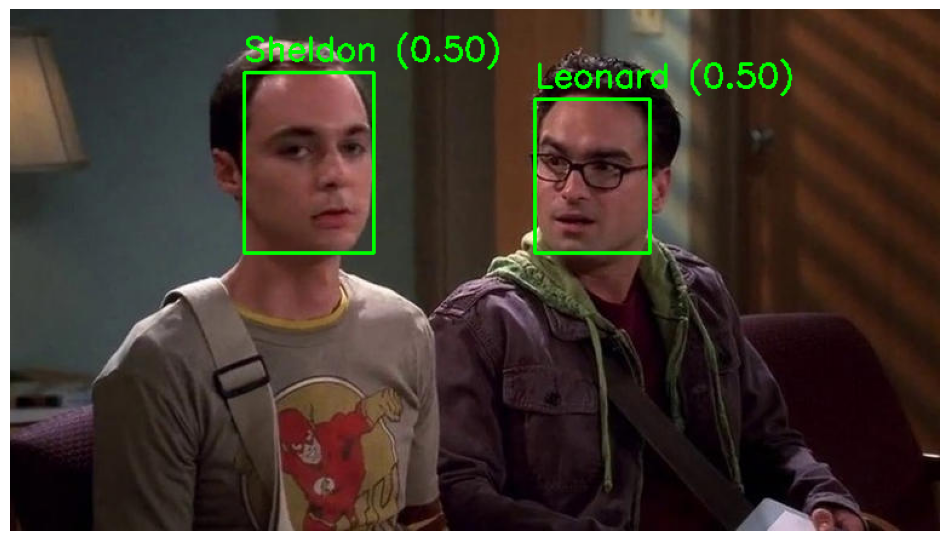

In [24]:
#Test the model
def test_recognition():
    print("Upload an image for testing")
    uploaded = files.upload()

    for filename in uploaded.keys():
        result = recognize_faces(filename)
        plt.figure(figsize=(12, 8))
        plt.imshow(result)
        plt.axis('off')
        plt.show()

test_recognition()